In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy.interpolate import SmoothBivariateSpline
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

import sys
sys.path.append("../")

from electronfactors.model.threshold import angle_gap, fit_give

from electronfactors.ellipse.utilities import _CustomBasinhopping

In [2]:
def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

In [4]:
with open("model_cache/6MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)

In [5]:
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

In [6]:
np.sum(book_factor)

4

In [7]:
# custom_label = label[~book_factor]
# custom_label = label[label != 'P3']

custom_label = label

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

In [8]:
len(width)

12

In [9]:
# factor[label == 'P3'] = 0.999

In [10]:
def to_eqPonA(width, length):
    ratio = width/length
    eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width
    
    return eqPonA

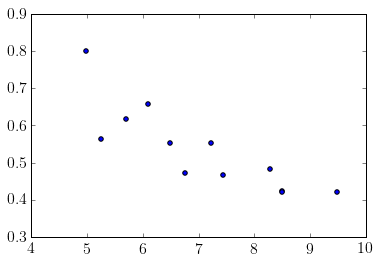

In [11]:
ratio = width/length
eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width

plt.scatter(width, eqPonA)

In [12]:
def multiregression(x, y, width, eqPonA, factor):
    regression = reg_m(factor, np.vstack([eqPonA, width]))
    paramaters = regression.params
    
    result = x*paramaters[0] + y*paramaters[1] + paramaters[2]
    
    return result

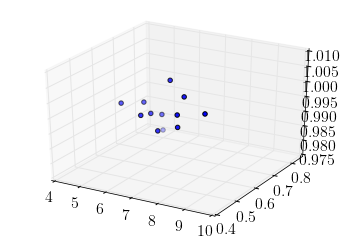

In [13]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(width, eqPonA, factor)

In [14]:
# factorTest = eqPonA * factor
# plt.scatter(width, factorTest)

In [15]:
# initial = np.array([0])
# step_noise = np.array([90])

# def to_minimise(optimiser_input):
#     rotated = aff.rotate(to_be_aligned, optimiser_input[0])

#     disjoint_area = (
#         rotated.difference(alighn_to_this).area +
#         alighn_to_this.difference(rotated).area
#     )
#     return disjoint_area

# optimiser = _CustomBasinhopping(
#     to_minimise=to_minimise,
#     initial=initial,
#     step_noise=step_noise,
#     n=2,
#     confidence=0.0001
# )

In [16]:
y = factor
x = np.vstack([width, eqPonA])

print(reg_m(y, x).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     8.968
Date:                Mon, 01 Jun 2015   Prob (F-statistic):            0.00720
Time:                        20:58:34   Log-Likelihood:                 47.623
No. Observations:                  12   AIC:                            -89.25
Df Residuals:                       9   BIC:                            -87.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0458      0.026     -1.775      0.1

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  int(n))


In [17]:
reg_m(y, x).params[0]

-0.045824243461369374

In [18]:
def create_model(width, eqPonA, factor):
    
    
    dependent_variable = factor
    independent_variables = np.vstack([width, eqPonA])
    multivariate_parameters = reg_m(
        dependent_variable, independent_variables).params

    initial = np.array([multivariate_parameters[0]])
    step_noise = np.abs(0.3 * initial)

    def to_minimise(optimiser_input):        
        factorTest = factor - eqPonA*optimiser_input
        spline = UnivariateSpline(width, factorTest)        
        predicted = spline(width) + eqPonA*optimiser_input
        residuals = predicted - factor

        return np.sum(residuals**2)

    optimiser = _CustomBasinhopping(
        to_minimise=to_minimise,
        initial=initial,
        step_noise=step_noise,
        n=2,
        confidence=0.00001
    )
    
    coeff = optimiser.result[0]
    print(coeff)
    
    def model(x, y):

        factorTest = factor - eqPonA*coeff

        spline = UnivariateSpline(width, factorTest)

        result = spline(x) + y*coeff
    
        if type(result) is np.float64:
            result = np.array(result)
            
        min_eqPonA = to_eqPonA(min(width), min(width))
        max_eqPonA = to_eqPonA(max(width), max(width))
    
        min_result = spline(min(width)) + min_eqPonA*coeff
        max_result = spline(max(width)) + max_eqPonA*coeff
        
        below_bounds = x < min(width)
        above_bounds = x > max(width)
        
        result[below_bounds] = min_result
        result[above_bounds] = max_result
        

        return result
    
    return model

In [19]:
model = create_model(width, eqPonA, factor)

-0.0364872044475


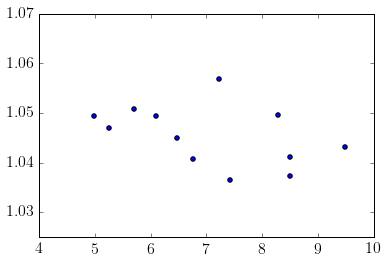

In [20]:
factorTest = factor - eqPonA*-0.09039
plt.scatter(width, factorTest)

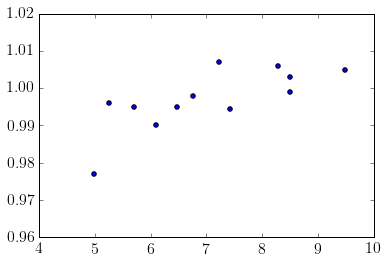

In [21]:
plt.scatter(width, factor)

In [22]:
factor - (width * 0.0045 - eqPonA * 0.0817 + 1.0102)

array([-0.00409106, -0.01488222,  0.00937221, -0.01123061,  0.00084728,
        0.00962534,  0.00977051, -0.01104003, -0.01348687, -0.00203894,
        0.00601276,  0.00815915])

In [23]:
eqPonA * 0.0817

array([ 0.03852894,  0.03456778,  0.04510721,  0.03810439,  0.04520728,
        0.05047534,  0.06542551,  0.03440997,  0.03441813,  0.03942106,
        0.05361776,  0.04602915])

In [24]:
y = factor
x = np.vstack([width, eqPonA])
print(reg_m(y, x).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     8.968
Date:                Mon, 01 Jun 2015   Prob (F-statistic):            0.00720
Time:                        20:58:35   Log-Likelihood:                 47.623
No. Observations:                  12   AIC:                            -89.25
Df Residuals:                       9   BIC:                            -87.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0458      0.026     -1.775      0.1

/usr/local/lib/python3.4/dist-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  int(n))


In [25]:
test = reg_m(y, x)
test.params

array([-0.04582424,  0.00120134,  1.01318116])

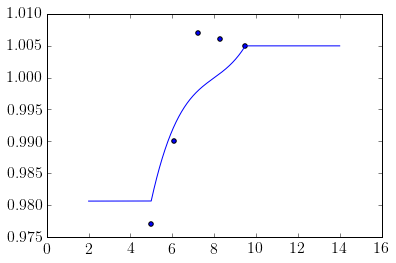

In [26]:
circle_test_width = np.linspace(2, 14, 1000)
circle_test_eqPonA = to_eqPonA(circle_test_width, circle_test_width)

circle_test_prediction = model(circle_test_width, circle_test_eqPonA)
plt.plot(circle_test_width, circle_test_prediction)
circle_ref = np.abs(width - length) < 0.1
plt.scatter(width[circle_ref], factor[circle_ref])

In [27]:
x = np.arange(2,14,0.1)
y = x

xx, yy = np.meshgrid(x,y)
   
mesh_width = xx.copy()
mesh_width[xx>yy] = yy[xx>yy]

mesh_length = xx.copy()
mesh_length[yy>xx] = yy[yy>xx]

mesh_ratio = mesh_width / mesh_length

mesh_eqPonA = 2*( 3*(mesh_ratio+1) - np.sqrt( (3*mesh_ratio+1)*(mesh_ratio+3) ) ) / mesh_width

zz = model(mesh_width, mesh_eqPonA)
give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)
gap = angle_gap(mesh_width, mesh_eqPonA, width, eqPonA, 1, 1)

outOfTolerance = (give > 0.5) | (gap > 180)

zz[outOfTolerance] = np.nan
    
zz = np.floor(zz*1e4)/1e4

(0.0, 16.0, 0.0, 16.0)

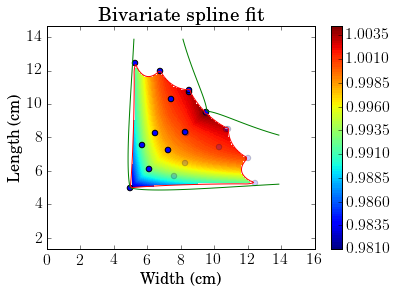

In [28]:
c = plt.contourf(xx,yy,zz,100)
plt.colorbar(c)

plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='r')

plt.scatter(width, length, s=30)
plt.scatter(length, width, s=30, alpha=0.2)

plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
plt.title('Bivariate spline fit')

plt.axis('equal')

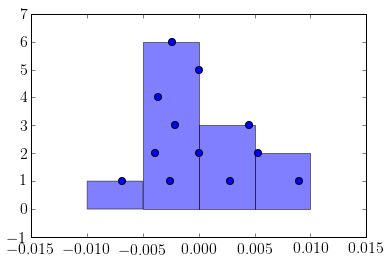

In [29]:
residuals_lengthwidth = factor - model(width, eqPonA)

binSize = np.floor(4 * residuals_lengthwidth.ptp() / len(residuals_lengthwidth) / 0.0005) * 0.0005
binStart = np.floor(residuals_lengthwidth.min()/binSize)*binSize
binEnd = np.ceil(residuals_lengthwidth.max()/binSize)*binSize

bins = np.arange(binStart,binEnd+binSize,binSize)

dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - residuals_lengthwidth),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):
    binRef = (binNum == i)
    representative_height[binRef] = np.arange(sum(binRef)) + 1

plt.hist(residuals_lengthwidth,bins,alpha=0.5)
plt.scatter(residuals_lengthwidth,representative_height,zorder=2,s=50,)

In [30]:
label[np.argsort(np.abs(residuals_lengthwidth))][::-1]

array(['Simon 7.25cm_6MeV', 'P35_2', 'Simon 8.3cm_6MeV',
       'Simon 5.3x12.5cm_6MeV', 'P6', 'Simon 5cm_6MeV', 'P7',
       'Simon 6.7x12cm_6MeV', 'Simon 6.1cm_6MeV', 'P24',
       'Simon 9.5cm_6MeV', 'Simon 8.5x10.9cm_6MeV'], 
      dtype='<U21')

In [31]:
np.std(residuals_lengthwidth)

0.0043852246459161947

In [32]:
np.argmax(np.abs(residuals_lengthwidth))

2

In [33]:
# label[20]

In [34]:
from scipy.special import gamma

def c4(n):
    
    output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
    if np.isnan(output):
        output = 1
        
    return output

-0.0425080883327
-0.0400051701203
-0.0559991066361
-0.0418140931064
-0.0360769325551
-0.0357200560486
0.0122898566594
-0.0364992826164
-0.0366431884922
-0.0431635354436
-0.0277780482314
0.020474565164
0.0099452842863
-8.05019386285e-05


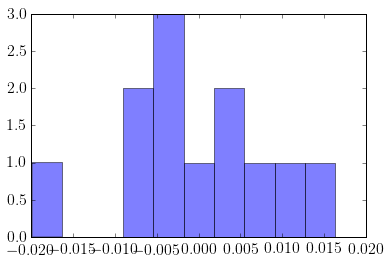

In [35]:
predictionValue = np.zeros(len(custom_label))
# bbox = [
#     min(width) - width.ptp()*0.2,
#     max(width) + width.ptp()*0.2, 
#     min(eqPonA) - eqPonA.ptp()*0.2,
#     max(eqPonA) + eqPonA.ptp()*0.2]

for i in range(len(custom_label)):

    widthTest = np.delete(width, i)
    eqPonATest = np.delete(eqPonA, i)
    factorTest = np.delete(factor, i)
    
    modelTest = create_model(widthTest, eqPonATest, factorTest)

#     predictionTestSpline = SmoothBivariateSpline(
#         widthTest, eqPonATest, factorTest, kx=2, ky=1)

    predictionValue[i] = modelTest(width[i], eqPonA[i])


predictionDifference = factor - predictionValue

plt.hist(predictionDifference, alpha=0.5)

predictionStd = np.std(predictionDifference, ddof=1) / c4(len(predictionDifference))

print(predictionStd)
print(np.mean(predictionDifference))

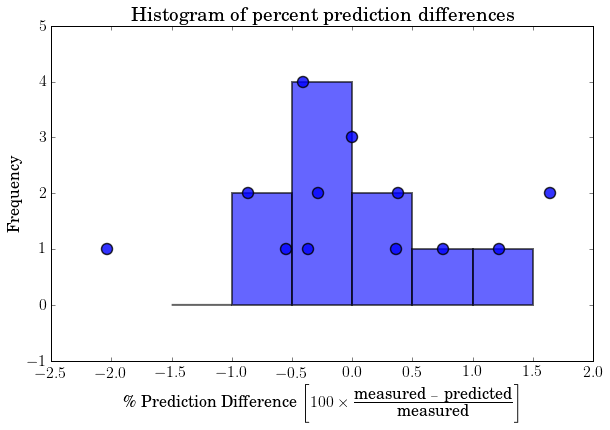

In [36]:
plt.figure(figsize=(6 * 1.618, 6))

percentDifference = 100*(factor - predictionValue) / factor

binStart = -1.5
binEnd = 1.5
binSize = 0.5

bins = np.arange(binStart, binEnd+binSize, binSize)


dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - percentDifference),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):

    binRef = (binNum == i)

    representative_height[binRef] = np.arange(sum(binRef)) + 1


plt.hist(percentDifference,bins, alpha=0.6, lw=2)
plt.scatter(percentDifference, representative_height, zorder=2, s=120, alpha=0.8, lw=1.5)

plt.xlabel(
    r'\% Prediction Difference '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of percent prediction differences')

In [37]:
label[np.argsort(np.abs(percentDifference))][::-1]

array(['Simon 5cm_6MeV', 'Simon 5.3x12.5cm_6MeV', 'Simon 7.25cm_6MeV',
       'P35_2', 'Simon 8.3cm_6MeV', 'P6', 'Simon 6.1cm_6MeV',
       'Simon 9.5cm_6MeV', 'Simon 6.7x12cm_6MeV', 'P7', 'P24',
       'Simon 8.5x10.9cm_6MeV'], 
      dtype='<U21')

In [38]:
np.max(np.abs(percentDifference))

2.0347992521792828

In [39]:
from scipy.stats import shapiro, probplot, ttest_1samp

In [40]:
t, ttestProb = ttest_1samp(percentDifference,0)
res_ttest = "%0.4f" %(ttestProb)

if ttestProb < 0.1:
    tSignificance = 'significant'
else:
    tSignificance = 'not significant'

print('t-Test: ' + res_ttest + ' which is ' + tSignificance)

W, shapiroProb = shapiro(percentDifference)
res_norm = "%0.4f" %(shapiroProb)

if shapiroProb < 0.1:
    shSignificance = 'significant'
else:
    shSignificance = 'not significant'

print('Shapiro: ' + res_norm + ' which is ' + shSignificance)



residualStd = np.std(percentDifference,ddof=1) / c4(len(percentDifference))

res_std = "%0.2f" %(residualStd)
print('Standard deviation with bias correction: ' + res_std)

res_mean = "%0.2f" %(np.mean(percentDifference))
print('Mean:' + res_mean)

t-Test: 0.9629 which is not significant
Shapiro: 0.9477 which is not significant
Standard deviation with bias correction: 1.00
Mean:-0.01


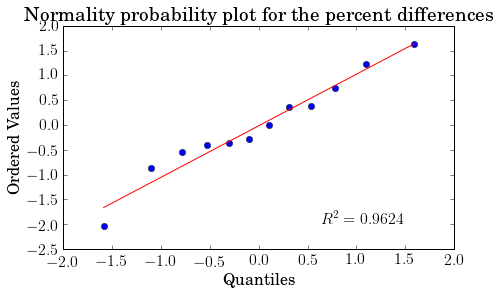

In [41]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(percentDifference, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

In [42]:
predictions = model(width, eqPonA)

numTrials = 5000

resampleSpline = [0,]*numTrials
resampledPredictions = np.zeros(np.shape(mesh_width) + (numTrials,))

for i in range(numTrials):

    resample = np.random.normal(loc=predictions, scale=predictionStd)
    resampleSpline[i] = SmoothBivariateSpline(width, eqPonA, resample, kx=2, ky=1)

    resampledPredictions[:,:,i] = resampleSpline[i].ev(mesh_width, mesh_eqPonA)

(0.0, 16.0, 0.0, 16.0)

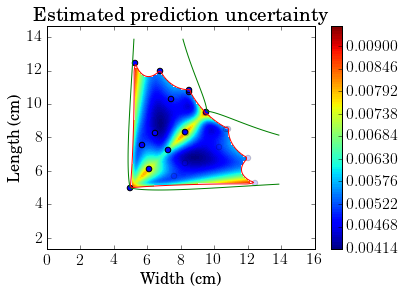

In [43]:
variableUncertaintyEstimate = np.std(resampledPredictions, ddof=1, axis=2) / c4(numTrials)

variableUncertaintyEstimate[outOfTolerance] = np.nan

c = plt.contourf(xx, yy, variableUncertaintyEstimate, 100)
plt.colorbar(c)

plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='r')

plt.scatter(width,length,s=30)
plt.scatter(length,width,s=30,alpha=0.2)

plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
plt.title('Estimated prediction uncertainty')

plt.axis('equal')

In [44]:
from scipy.optimize import basinhopping

class constant_uncertainty(object):
    """Find the constant uncertainty throughout the fit.
    """
    def __init__(self, n=5, debug=False, **kwargs):
        
        self.debug=debug
        
        self.residuals = kwargs['residuals']
        self.variableUncertainty = kwargs['variableUncertainty']

                
        self.basinRequiredSuccess = n
        self.constantUncertainty = np.abs(self.uncertainty_basinhopping())
        
        self.totalUncertainty = np.sqrt(self.variableUncertainty**2 + 
                                        self.constantUncertainty**2)
        

    def c4(n):
    
        output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
        if np.isnan(output):
            output = 1

        return output
    
    
    def minimise_function(self, constantUncertaintyGuess):

        totalUncertaintyGuess = np.sqrt(self.variableUncertainty**2 + constantUncertaintyGuess**2)

        scaled = self.residuals / totalUncertaintyGuess

        scaledStd = np.std(scaled,ddof=1) / c4(len(scaled))
        
        return (scaledStd - 1)**2
        
    
    def uncertainty_basinhopping(self):

        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'BFGS'}
        
        initial_input = np.array([0.01])
        
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)
        
        return basinhoppingOutput.x
        
        
    def step_function(self,optimiserInput):

        optimiserInput[0] += np.random.normal(scale=0.01)   # x-position
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
       
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + 0.0001:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - 0.0001:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - 0.0001:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True
        

In [45]:
resampledPredictionsAtPoints = np.zeros(np.shape(width) + (numTrials,))

for i in range(numTrials):

    resampledPredictionsAtPoints[:,i] = resampleSpline[i].ev(width,eqPonA)

fittingUncertainty = np.std(resampledPredictionsAtPoints, ddof=1, axis=1) / c4(numTrials)
# fittingUncertainty

measuredUncertaintyEstimate = constant_uncertainty(residuals=predictionDifference, 
                                                   variableUncertainty=fittingUncertainty)

measuredUncertaintyEstimate.constantUncertainty

measuredUncertaintyString = '%0.2f%%' %(measuredUncertaintyEstimate.constantUncertainty*100)
print(measuredUncertaintyString)

0.58%


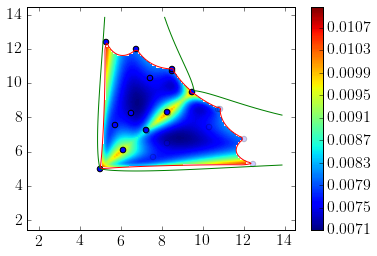

In [46]:
totalUncertaintyEstimate = np.sqrt(variableUncertaintyEstimate**2 + 
                                   measuredUncertaintyEstimate.constantUncertainty**2)

totalUncertaintyEstimate = np.around(totalUncertaintyEstimate,decimals=5)

c = plt.contourf(xx,yy,totalUncertaintyEstimate,200)
plt.colorbar(c)

plt.contour(xx,yy,give,levels=[0.5],colors='g')
plt.contour(xx,yy,gap,levels=[180],colors='r')

plt.scatter(width,length,s=30)
plt.scatter(length,width,s=30,alpha=0.2)